# Common evaluation framework

Goal of this notebook is to test the common evaluation framework. The test model will be ISA with discovery mode. 
Let's begin wuhuuu!

In [1]:
# imports 

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data_scclevr import makeRings 
from model import InvariantSlotAttention
from model import InvariantSlotAttention_disc

from matplotlib.patches import Circle
import json

import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from plotting import plot_chosen_slots, plot_kslots, plot_kslots_iters, plot_kslots_grads

torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

%load_ext autoreload
%autoreload 2

### Load the model

In [2]:
device = 'cpu'

cID_prev = 'isa-discovery-mode2'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

cd

{'data': {'N_clusters': 2, 'isRing': True},
 'hps': {'hidden_dim': 16,
  'k_slots': 3,
  'query_dim': 128,
  'pixel_mult': 0.2,
  'device': 'cpu'},
 'opt': {'lr': 0.0003, 'Ntrain': 20000, 'bs': 256}}

In [3]:
model = InvariantSlotAttention_disc(**hps)

In [4]:
f = open(f'./../../code/models/{cID_prev}/loss.json')
# returns JSON object as a dictionary
losses = json.load(f)

loss  mse  min:  1.847102168994752e-07  at  15984


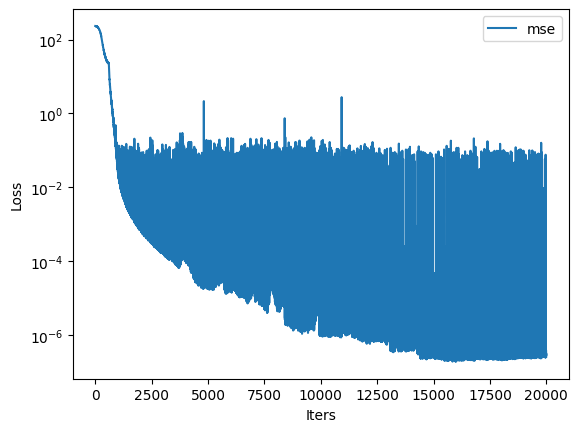

In [5]:
for k,v in losses.items():
    if k=="mse":
        plt.plot(v,label=k)
        print("loss ", k, " min: ", np.min(v), " at ", np.argmin(v))
plt.xlabel('Iters')
plt.yscale("log")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
lastIter = 16000
weightPath = f'./../../code/models/{cID_prev}/m_{lastIter}.pt'
print(f'Starting from an earlier training',lastIter)

model.load_state_dict(torch.load(weightPath,map_location=device))

Starting from an earlier training 16000


<All keys matched successfully>

### Evaluate the model

Use the common evaluation framework

In [9]:
import scclevr
os.sys.path.append('./../../../evaluation')
from dataset import TestDataset
import model_performance as ev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ds = TestDataset()

In [11]:
X = torch.FloatTensor(ds.event_images).to(device)
X.shape

torch.Size([5000, 1, 32, 32])

In [12]:
with torch.no_grad():
    queries, att, y_pred, alpha = model(X)

In [40]:
mp = ev.Model_performance(ds, att)

In [41]:
mp.mask_pred.shape

torch.Size([5000, 3, 1024])

In [42]:
mp.hungarian_matching()

In [43]:
mp.mask_pred.shape

torch.Size([5000, 2, 1024])

**Note:** See how sizes change after the hungarian matching. The background slot automatically vanished. This should also work when their is no background slot at all (not slot attention)

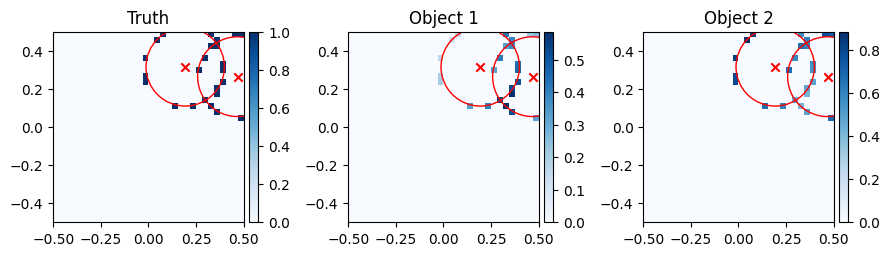

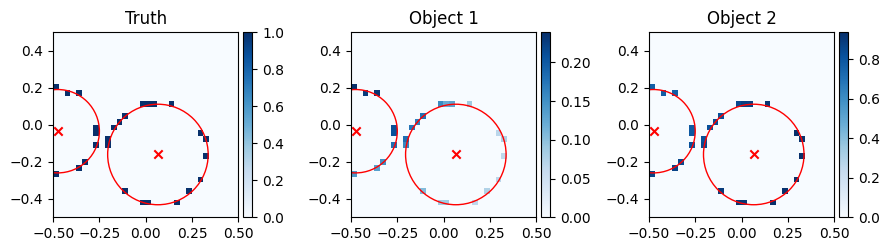

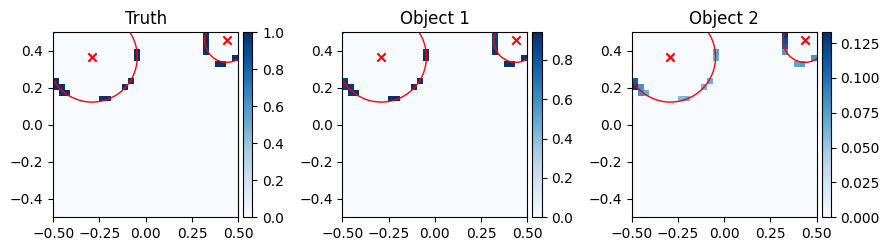

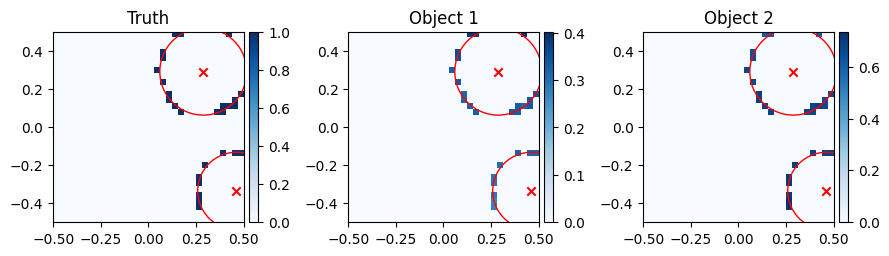

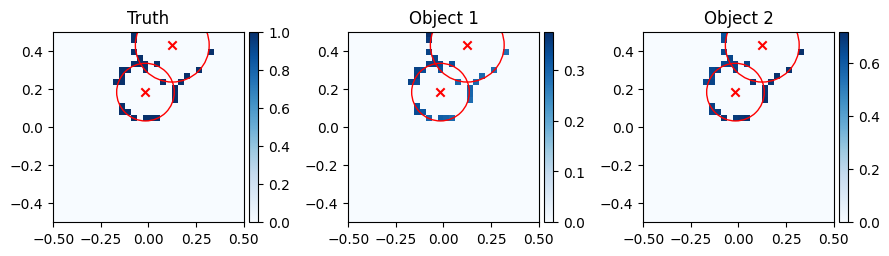

In [44]:
for i in range(5):
    mp.plot_instance_i(i)

Ok, so the hungarian matching seems to work! Only in one picture out of 100 there was a background slot...

In [45]:
loss = mp.KL_loss()
np.log10(loss)

tensor(-3.0515)

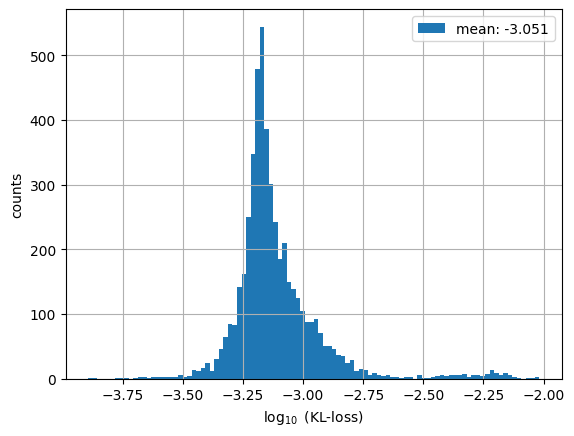

In [46]:
mp.loss_hist()

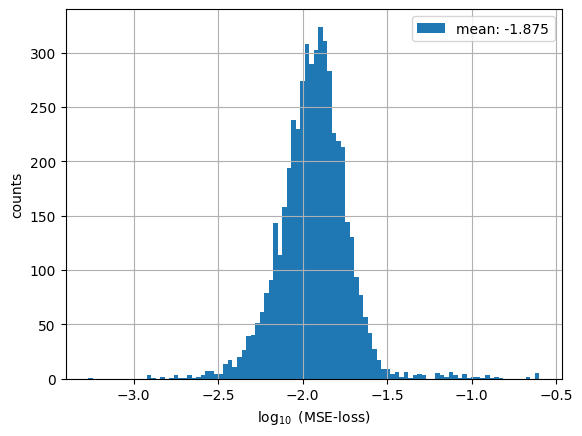

In [51]:
mp.loss_hist(loss="MSE", log=True)

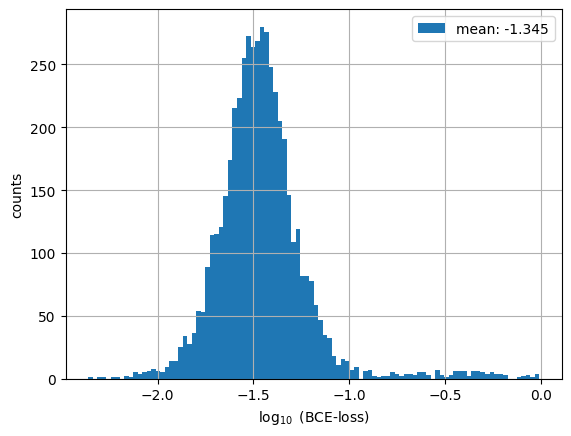

In [50]:
mp.loss_hist(loss="BCE", log=True)